# Final project: Finding the suspect

<a href="https://en.wikipedia.org/wiki/Facial_composite">Facial composites</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques is evolutionary systems that compose the final face from many predefined parts.

In this project, we will try to implement an app for creating a facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

The final project is developed in a way that you can apply learned techniques to real project yourself. We will include the main guidelines and hints, but a great part of the project will need your creativity and experience from previous assignments.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [ ]:
! pip install GPy GPyOpt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import GPyOpt
import keras
import utils, vae
import pickle, re, sys
import pandas as pd
%matplotlib inline

### Grading
As some of the final project tasks can be graded only visually, the final assignment is graded using the peer-review procedure. You will be asked to upload your Jupyter notebook on the web and attach a link to it in the submission form. Detailed submission instructions and grading criterions are written at the end of this notebook.

## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is dense. That means that we can traverse the latent space and reconstruct any point along our path into a valid face.

Using this continuous latent space we can use Bayesian optimization to maximize some similarity function between a person's face in victim/witness's memory and a face reconstructed from the current point of latent space. Bayesian optimization is an appropriate choice here since people start to forget details about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Generating faces

For this task, you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Aligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model for you. See optional part of the final project if you wish to train VAE on your own.

**Task 1:** Train VAE on faces dataset and draw some samples from it. (You can use code from previous assignments. You may also want to use convolutional encoders and decoders as well as tuning hyperparameters)

### Answer to Task 1: Dataset and Conditional VAE model

Since I was curious too see if I would be able to improve upon the provided pre-trained model, I decided to experiment a little with the extensions and techniques shown during the course and in the referenced literature. In the end, I implemented the following additional features compared to the baseline VAE model (all implementations in module vae.py):

1. I created a labelled data set based on the CelebA collection and selected in total 52000 images (44000 for training and 8000 for validation), where each of the four classes (younger females, older females, younger males, older males) are represented with an equal amount of samples (13000 each). With this labelled data set, I trained a conditional VAE as in week 5, hoping that it would allow me to generate more realistic faces. On the other hand, that also means that in addition to the latent space, the Bayesian optimization scheme has to search the label space, which is given by the simplex $S = \{ (x_1,\ldots,x_4) \in R^4 \vert \sum x_i = 1 \;\text{and}\; x_i \ge 0 \}$, which is a 3 dimensional manifold embedded in $R^4$.


2. In an attempt to improve the learning of the variational distribution $q(T \vert X, \phi)$ of latent variable $T$ given and input image $X$ and encoder weights $\phi$, I subclassed Keras layers that implement the planar normalizing flows from the paper *Variational Inference with Normalizing Flows* by D. J. Rezende and S. Mohamed. The model that I trained has 16 flow layers (see below).


3. For the posterior $P(X \vert T, \theta)$ of the image probability given the latent variable $T$ and the decoder weights $\theta$, I wanted the let the model learn a distribution that takes values between 0 and 1 for each pixel. Therefore, I chose a factorized beta distribution $B(\alpha_i, \beta_i)$ with parameters $\alpha_i, \beta_i > 0$ that could be different for each of the $64 \times 64 \times 3 = 12288$ pixels and channels of the output image. The model learned the logarithms of each of these $\alpha_i$ and $\beta_i$. Individual pixel values $v_i$ of the output images are given by the mean of the corresponding beta distibution $\alpha_i / (\alpha_i + \beta_i)$, where $i = 1,\ldots,12288$. In total, my model has $2 \times 12288 = 24576$ output nodes. It turned out that although this ansatz is valid, numerically stable, and suitable to generate nice faces, it also tends to produce noticable artifacts, particularly in parts of the backgrounds, that look a little like checkerboard patterns.

In [2]:
#Image and label dimensions
imgRows = imgCols = 64
img_size = [imgCols, imgRows]
img_dim = imgRows * imgCols * 3
lbl_dim = 4
tot_dim = img_dim + lbl_dim

In [ ]:
# training and validation datasets and hyperparameters
# (this is just for illustration purposes, I didn't actually upload the images)
batch_size = 128
nbrTrainSmps = 44000
nbrTestSmps = 8000
shuffle_buffer_size = 1000

train_ds = utils.create_img_ds( '/home/spyder/data/train', img_size ).\
            prefetch( buffer_size=tf.data.experimental.AUTOTUNE ).\
            cache().shuffle(buffer_size=shuffle_buffer_size).repeat().\
            batch(batch_size).map(lambda x: (x,x))

test_ds = utils.create_img_ds( '/home/spyder/data/test', img_size ).\
            prefetch( buffer_size=tf.data.experimental.AUTOTUNE ).\
            cache().repeat().batch(batch_size).map(lambda x: (x,x))

In [3]:
# model hyper parameters
filters=[64, 128, 128, 256] # four convolutional layers for encoder and decoder (reversed)
latent_dim=16               # dimension of latent space
flows=16                    # number of planar normalizing flows
lr=0.0001                   # learning rate
use_beta=True               # use factorized beta distribution for p(X|T)
dropout=0                   # dropout rate (no dropout)

In [4]:
training = False # whether to create a new model, train and save it or just load a pre-trained one
file_path = 'cvae.nn'

if training:
    epochs = 300
    mdl = vae.create_vae(
        img_size,
        filters,
        lbl_dim=lbl_dim,
        latent=latent_dim,
        flows=flows,
        learning_rate=lr,
        use_beta=use_beta,
        dropout=dropout
    )
    ESC = keras.callbacks.EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)
    hist = mdl.fit(x=train_ds,
            epochs=epochs,
            steps_per_epoch=nbrTrainSmps//batch_size + 1,
            validation_data=test_ds,
            validation_steps=nbrTestSmps//batch_size + 1,
            callbacks=[ESC],
            verbose=1)
    mdl.save(file_path)

else:
    mdl = vae.load_vae(file_path)

decoder = mdl.decoder

#### GRADED 1 (3 points): Draw 25 samples from trained VAE model
As the first part of the assignment, you need to become familiar with the trained model. For all tasks, you will only need a decoder to reconstruct samples from a latent space.

To decode the latent variable, you need to run ```decode``` operation defined above with random samples from a standard normal distribution.

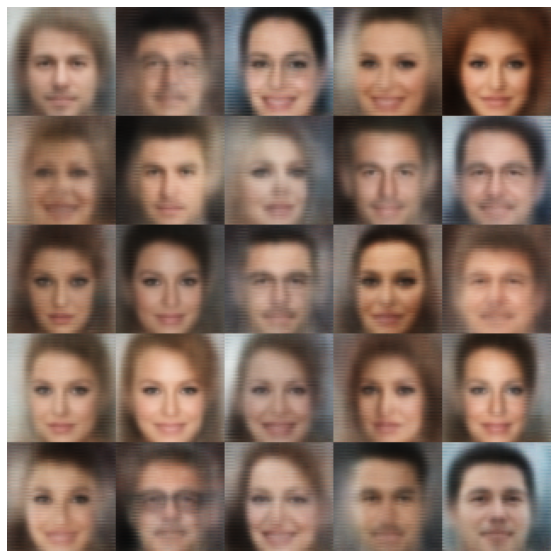

In [9]:
"""
Since I trained a CVAE, the user can provide a label in order to generate faces from one of four
classes (or mixtures thereof). Examples:
    label = None                     # choose label randomly for each image (default)
    label = [1.0, 0.0, 0.0, 0.0]     # younger males
    label = [0.0, 1.0, 0.0, 0.0]     # older males
    label = [0.0, 0.0, 1.0, 0.0]     # younger females
    label = [0.0, 0.0, 0.0, 1.0]     # older females
    label = [0.0, 0.0, 0.5, 0.5]     # females (mixture of younger and older)
    label = [0.25, 0.25, 0.25, 0.25] # something between male and female
"""
label = None

nbrRows = nbrClms = 5
image = np.zeros( (imgRows * nbrRows, imgCols * nbrClms, 3) )
byts = decoder.generate_images( nbrRows * nbrClms, lbl=label )
plt.figure(figsize=(2 * nbrRows, 2 * nbrClms))
for row in range(nbrRows):
    for clm in range(nbrClms):
        image[
            row * imgRows: (row + 1) * imgRows,
            clm * imgCols: (clm + 1) * imgCols, :
        ] = byts[row * nbrClms + clm]
plt.imshow(image)
plt.axis('off')
plt.show()

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that you want to generate an image of Brad Pitt. You start with a small number of random samples, say 5, and rank them according to their similarity to your vision of Brad Pitt: 1 for the worst, 5 for the best. You then rate image by image using GPyOpt that works in a latent space of VAE. For the new image, you need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). A user then enters score to a current image.

The proposed scoring has a lot of drawbacks, and you may feel free to come up with new ones: e.g. showing user 9 different images and asking a user which image looks the "best".

Note that the goal of this task is for you to implement a new algorithm by yourself. You may try different techniques for your task and select one that works the best.

<b>Task 2:</b> Implement person search using Bayesian optimization. (You can use code from the assignment on Gaussian Processes)

Note: try varying `acquisition_type` and `acquisition_par` parameters.

In [14]:
class FacialComposit:
    
    eps = 0.001 # boundary margin for unit cube <-> simplex mapping in label dimensions
    
    def __init__(self, decoder, bounds, flow=True):
        self.latent_dim = decoder.latent
        self.decoder = decoder
        self.samples = None
        self.images = None
        self.rating = None
        self.shifts = -np.array( bounds[:,0] )
        self.widths = np.array( bounds[:,1] ) + self.shifts
        self.dim = decoder.latent + decoder.lbl_dim - 1
        self.flow = flow
        # all latent coordinates are mapped to the unit cube:
        self.bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (0.0, 1.0) }
                  for i in range(decoder.latent)]
        # label space is mapped from n-dimensional simplex to
        # interior of (n-1)-dimensional unit cube
        self.bounds += [{'name': 'z_{0:03d}'.format(i + decoder.latent),
                   'type': 'continuous',
                   'domain': (FacialComposit.eps, 1.0 - FacialComposit.eps) }
                  for i in range(decoder.lbl_dim - 1)]

    @staticmethod
    def _show_images(images, scores, cols=5):
        assert len(images) == len(scores)
        clear_output()
        n = len(scores)
        rows = n // cols + (1 if n % cols != 0 else 0)
        plt.figure(figsize=(3*cols, 3*rows))
        for i in range(n):
            plt.subplot(rows, cols, i+1)
            plt.imshow(images[i])
            score = -1.0 * scores[i]
            plt.axis('off')
            if i < cols: # upper column labels
                plt.title(str(i), fontsize=15)
            if i % cols == 0: # left row labels
                plt.text( -10, 36, str(i // cols), fontsize=15 )
            if i % cols == cols - 1: # right row labels
                plt.text( 68, 36, str(i // cols), fontsize=15 )
            if i // cols == rows - 1: # bottom column labels
                plt.text( 30, 74, str(i % cols), fontsize=15 )

            if not np.isnan(score): # currently assigned image score
                plt.text( 48, 70, str(score), fontweight='bold', fontsize=12, color='xkcd:dark red' )
        plt.subplots_adjust(left=0.2, bottom=0.2)
        plt.show()

    @staticmethod
    def _draw_border(image, w=2, color=[1,0,0]):
        bordered_image = image.copy()
        bordered_image[:, :w] = color
        bordered_image[:, -w:] = color
        bordered_image[:w, :] = color
        bordered_image[-w:, :] = color
        return bordered_image

    @staticmethod
    def _cube2simplex( x ):
        dim = len(x)
        assert np.min(x) >= 0.0 and np.max(x) <= 1.0, "invalid cube point"
        if dim == 1:
            return np.array([ x[0], 1.0 - x[0] ])
        return np.concatenate(
            (
                np.array([x[0]]),
                (1.0 - x[0]) * FacialComposit._cube2simplex( x[1:] )
            )
        )
    
    @staticmethod
    def _simplex2cube( y ):
        dim = len(y)
        assert dim > 0 and np.min(y) >= 0.0 and np.abs( np.sum(y) - 1.0 ) < 1.0e-4, \
            "invalid simplex point: " + str(y)
        eps = FacialComposit.eps
        if dim == 1:
            return np.array([])
        if dim == 2:
            return np.array( np.clip( [ y[0] ], [eps], [1.0 - eps] ) )
        if y[0] + eps > 1.0:
            x = np.empty( [dim - 1] )
            x[:] = eps
            x[0] = 1.0 - eps
            return x
        y0 = np.max( (y[0], eps) )
        yp = np.copy(y[1:])
        yp[ np.argmax(yp) ] -= (eps - y[0])
        yp /= (1.0 - y0)
        yp /= np.sum(yp)
        return np.concatenate(
            (
                np.array([ y0 ]),
                FacialComposit._simplex2cube( yp )
            )
        )        
    
    def query_initial(self, n_start=25, min_select=5, max_select=10, ref_points_path=None):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: pool of images to rank initially.
        :param min_select: minimum number of images to score
        :param max_select: maximum number of images to score
        :param ref_points_path: path to collection of preselected reference points
                                (faces with characteristic features like beards, glasses, etc.)
        '''
        
        self.rating = np.empty( [n_start] )
        self.rating[:] = np.nan
        if ref_points_path is None:
            self.samples, self.images = decoder.generate_images( n_start, flow=self.flow, with_samples=True )
        else:
            with open(ref_points_path, 'rb') as f:
                self.samples = pickle.load(f)
                f.close()
            nbrRefSmps = len(self.samples)
            if nbrRefSmps > n_start:
                self.samples = self.samples[:n_start]
            elif nbrRefSmps < n_start:
                self.samples = tf.concat(
                    [ self.samples, self.decoder.sample( n_start - nbrRefSmps ) ],
                    axis=0
                )
            self.samples = tf.random.shuffle( self.samples )
            self.images = self.decoder.image_from_sample( self.samples, flow=self.flow )
        self.samples = self.samples.numpy()
        
        idxs = []
        while True:
            self._show_images( self.images, self.rating )
            usrStr = input( 'input row, col, and score (\'q\' for quit): ' )
            if usrStr == 'q':
                break
            mtc = re.match( '^([0-9 ]+),([0-9 ]+),([0-9\.\- ]+)$', usrStr )
            if mtc is None:
                print('invalid input')
                continue
            row, col, score = int(mtc[1]), int(mtc[2]), float(mtc[3])
            idx = row * 5 + col
            if idx > n_start:
                print('invalid image coordinates')
                continue
            self.rating[idx] = -1.0 * score
            idxs += [idx]
            idxs = sorted( set(idxs) )
            if len(idxs) == max_select or len(idxs) == len(self.samples):
                break
        assert len(idxs) >= min_select, "Please score at least " + str(min_select) + " images!"

        if len(idxs) < len(self.samples):
            print( "Do you want to set the score for all unassigned images to zero?" )
            usrStr = input( "[y/N]" )
            if re.match( '^[yY]([eE][sS])?$', usrStr ) is None:
                self.samples = self.samples[ idxs, ... ]
                self.images = self.images[ idxs, ... ]
                self.rating = self.rating[ idxs ]
            else:
                diff = list( set(range(n_start)) - set(idxs) )
                self.rating[diff] = -0.0
        
        # map all label dimensions from simplex to (interior of) unit cube
        self.samples = np.concatenate(
            (
                self.samples[:,:self.latent_dim],
                np.apply_along_axis( FacialComposit._simplex2cube, 1, self.samples[:,self.latent_dim:] )
            ),
            axis=1
        )
        # map all latent dimensions to unit cube
        self.samples += self.shifts
        self.samples /= self.widths
        
        self.initial_size = len(self.samples)

    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: vector of size 1 x (latent_dim + lbl_dim - 1)
        '''
        initial_size = len(self.images)
        
        # transform candidate from unit cube to (latent,label) space
        sample = candidate.reshape( [self.dim] )
        sample *= self.widths
        sample -= self.shifts
        sample = np.concatenate(
            (
                sample[:self.decoder.latent],
                FacialComposit._cube2simplex( sample[self.decoder.latent:] )
            )
        ).reshape( [1, self.dim + 1] )
        image = decoder.image_from_sample( sample, flow=self.flow ).reshape( self.decoder.image_size )

        # get list of best images according to user rating
        max_nbr_imgs = 5
        
        rating = pd.Series( self.rating )
        rating.sort_values( ascending=True, inplace=True )
        idxs = rating.index[:max_nbr_imgs]
        best_images = self.images[ idxs, ... ]
        best_scores = self.rating[ idxs, ... ]

        # show candidate image along with current best 5 images
        rows, cols = 2, max_nbr_imgs
        clear_output()
        plt.figure(figsize=(3 * cols, 3 * rows))
        plt.subplot(rows, cols, 1)
        plt.imshow(image)
        plt.title('candidate')
        plt.axis('off')
        for i, (img, score) in enumerate( zip( best_images, best_scores ) ):
            plt.subplot(rows, cols, i+cols+1)
            plt.imshow(img)
            plt.axis('off')
            plt.text( 48, 70, str(-1.0 * score), fontweight='bold', fontsize=12, color='xkcd:dark red' )
        plt.subplots_adjust(bottom=0.1)
        plt.show()
        
        # let user score the candidate image
        while True:
            usrStr = input( 'candidate score (>=0, q for quit): ' )
            if usrStr == 'q':
                raise ValueError("Quit")
            try:
                candidate_rating = float(usrStr)
            except ValueError:
                print( 'invalid score. please try again' )
                continue
            if candidate_rating < 0.0:
                print( 'score must be >= 0' )
            break
        image = image.reshape( [1] + self.decoder.image_size )
        candidate_rating *= -1.0
        
        self.samples = np.concatenate( (self.samples, candidate) )
        self.images = np.concatenate( (self.images, image)  )
        self.rating = np.append( self.rating, candidate_rating )
        
        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating

    def optimize(self, n_iter=10, ref_points_path=None, exploration_weight=2):

        if self.samples is None:
            self.query_initial(ref_points_path=ref_points_path)
            
        space = GPyOpt.Design_space( self.bounds )
        objective = GPyOpt.core.task.SingleObjective( self.evaluate )
        model = GPyOpt.models.GPModel( exact_feval=False )
        acq_opt = GPyOpt.optimization.AcquisitionOptimizer( space )
        acq = GPyOpt.acquisitions.AcquisitionLCB(
            model,
            space,
            optimizer=acq_opt,
            exploration_weight=exploration_weight
        )
        optimizer = GPyOpt.methods.ModularBayesianOptimization(
            model,
            space,
            objective,
            acq,
            GPyOpt.core.evaluators.Sequential(acq),
            X_init=self.samples,
            Y_init=self.rating[:,None]
        )
        try:
            optimizer.run_optimization(max_iter=n_iter, eps=-1)
        except Exception as e:
            if str(sys.exc_info()[1]) == "Quit":
                print( 'Exiting...' )
            else: 
                raise e
 
    def get_best(self):
        index_best = np.argmin(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        plt.imshow( self.get_best() )
        plt.title(title)
        plt.axis('off')
        plt.show()
    
    def draw_all(self, title, cols=5 ):
        clear_output()
        n = len(self.rating)
        rows = n // cols + (1 if n % cols != 0 else 0)
        plt.figure(figsize=(3*cols, 3*rows))
        idx_best = np.argmin(self.rating)
        for idx in range(n):
            plt.subplot(rows, cols, idx + 1)
            if idx == idx_best:
                plt.imshow( self._draw_border(self.images[idx]) )
                plt.title(title, fontsize=15)
            else:
                img = self.images[idx]
                if idx < self.initial_size:
                    img = self._draw_border( img, color=[0.4,0.9,0.4] )
                plt.imshow(img)
                plt.title(str(idx), fontsize=15)
            score = -1.0 * self.rating[idx]
            plt.text( 48, 70, str(score), fontweight='bold', fontsize=12, color='xkcd:dark red' )
            plt.axis('off')
        plt.subplots_adjust(bottom=0.2, hspace=0.3, wspace=0.1)
        plt.show()
    
    def save_state(self, path):
        with open( path, 'wb') as f:
            pickle.dump( (self.initial_size, self.images, self.samples, self.rating ), f)
            f.close()        

    def load_state(self, path):
        with open( path, 'rb') as f:
            self.initial_size, self.images, self.samples, self.rating = pickle.load(f)
            f.close()

#### GRADED 2 (3 points):
Describe your approach below: How do you assign a score to a new image? How do you select reference images to help user assign a new score? What are the limitations of your approach?

**Answer:**

1. **Search Space:** First, in order to be able to utilize the *conditional* VAE, I had to find a way to let the Bayesian optimizer search in the combined space of latent space and label space. Since the labels are given by 4 dimensional positive real vectors whose components add up to 1.0 (simplex $S$), I use a mapping from $S$ to the 3 dimensional unit cube (_simplex2cube, _cube2simplex). In order to avoid problems at the boundaries of this cube, where the mapping would not be uniquely invertible, I let the optimizer search in the interior of the 3 dimensional unit cube given by $C := \{ (c_1, c_2, c_3) \vert \epsilon \le c_i \le 1 - \epsilon \}$ where $\epsilon = 0.001$. A potential advantage of using a CVAE for this kind of application is that you could effectively restrict the search space and therefore the number of images shown to the witness by, e.g., only generating images of men if you already know that the suspect was male. Unfortunately, this feature is not yet implemented.


2. **Bounds:** Since I used normalizing flows to transform the variational distibution $q(T\vert X)$, I have to set reasonable bounds for each dimension of the latent space and provide them as second argument to the constructor of the FacialComposit object. A possible advantage of the transformed distribution could be that faces with certain characteristic feature sets (e.g. male and female) end up well separated in latent space, which in turn could make it (potentially) easier for the Bayesian optimization to find good resemblances. Indeed, when I look at how a 16 dimensional standard normal distribution is transformed by the learnt flow layers, it seems that some dimensions represent well separated features (see next cell below). The whole search space is then mapped to the unit cube. All in all, the seach space has 19 = 16 + 3 dimensions. 


3. **Querying Initial Set of Images:** For the generation of the initial image set, I implemented the following basic scheme with a number of additional options:

    **a**) An initial set of *n_start* samples (default 25) is generated randomly or read from a file (parameter *ref_points_path*). If reference samples are loaded from a file and their number is less than *n_start*, the remaining samples are generated randomly.
    
    I actually assembled a selection of reference faces with a wide range of different distinctive features (file *cvae_reference_points.dat*) but did not use it for the graded tasks (3.1 to 3.3) as that could be considered too easy. If the application was to be used in a real-world scenario, however, using carefully constructed sets of initial images would be a very reasonable approach to increase search efficiency.

    **b**) In the beginning, none of the samples have a score (np.nan) and the user is asked to assign scores $\ge 0$ to those images that bear a resemblance to the suspect. With parameters *min_select* and *max_select* the user can set a minimum and maximum number of images to score. At any time, the user can type 'q' to terminate the initial query. If assigned, its score is shown below the lower right corner of the image.
    
    **c**) If there are still unscored images, when the user terminates the query, they are asked whether or not all remaining images should be getting a score of 0.0. This feature is intended for cases where the suspect's face has very destinctive features (e.g. mustache, glasses) and selecting only those (probably few) images with these features while setting all others to zero might result (I hope) in a better initial set to specifically search for faces with said features.
    
    **d**) Only samples with a score are kept and fed into the Bayesian optimization algorithm.


5. **Finding next Candidate:** Since I used Gaussian process optimization (GPO) to find an optimal point, the candidate is found by maximizing a suitable acquisition function. I tried a number of different settings for both the type of acquisition function and their paramters and ended up using the lower confidence bound (LCB) with a default exploration_weight of 2. However, as LCB can only be used to find a minimum of an objective, internally I had to multiply all image scores by -1.0 and instruct the Bayesian optimizer to minimize the negative score.

    Again, the user can terminate the optimization at any time by typing 'q'.


4. **Evaluation of Candidate:** The evaluation procedure is pretty straightforward. The candiate image is shown together with the (up to) five highest scored faces and their scores. The user is asked to rank the candiate in relation to those current favorites.


5. **Limitations:** The algorithm as it is implemented now has some severe limitations:

    **a**) Since the user cannot preselect a reasonable subgroup of faces up-front (e.g. young women with blond hair and glasses), they are shown much more faces than necessary. With a more properly trained CVAE with more lables and a larger data set along with carefully preselected sets of reference images, this problem could be mitigated while both reducing the length of the search and improving its result considerably.
    
    **b**) If one is looking for a person with "unlikely" (w.r.t the probability distribution given by the training set) features, many restarts are required to have even a single example in the initial set. In my case for example, it is very unlikely to randomly generate the face of a blond male with mustache.
    
    **c**) Even if the search results in a face that has most of the features needed, it is almost impossible to direct the search in such a way that remaining features can be added (for example, adding glasses). I tried to generate the face of Walter White from the TV series *Breaking Bad* and ended up with a bald older male with glasses. In a time-frame of over an hour I did not succeed in adding the goatee...
    
    **d**) As can be seen from task 3.3 (generating the face of a lecturer), it is very dificult with my trained model, to improve the resemblance of the face to that of a real person, once the the best faces are actually pretty close in the search space.
    
    The user gets presented lots of very similar looking faces which look "kind of" like the real person but not good enough to let even friends or relatives recognize them from the generated image (I think).
    
    As far as the model is concerned, I guess distance of points to optimum in search space is already quite small. For the user on the other hand, this process of looking at many very similar faces, trying to asses which one is better or worse takes a lot of time, is tedious and frustrating. And still the end result is not very convincing (at least) to me.
    
    I guess the quality of the CVAE model and of the search algorithm still need some work to yield usable results.

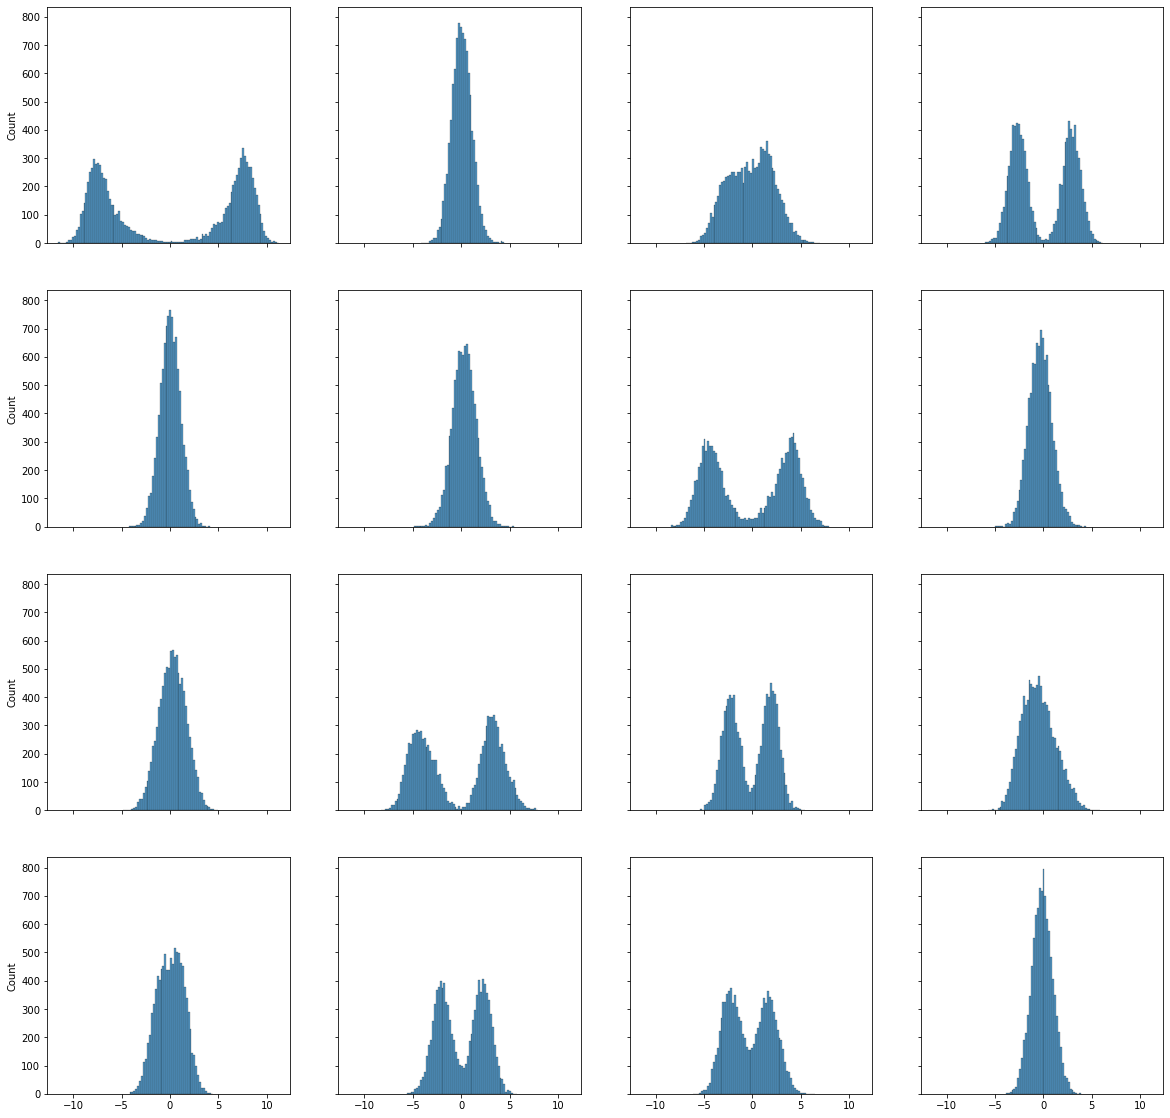

In [10]:
random_samples = decoder.sample(10000, flow=True).numpy()
import seaborn as sns
f, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
for row in range(4):
    for clm in range(4):
        sns.histplot( random_samples[ :, row * 4 + clm], ax=axes[row, clm], binwidth=0.2 )

## Testing your algorithm

In these sections, we will apply the implemented app to search for different people. Each task will ask you to generate images that will have some property like "dark hair" or "mustache". You will need to run your search algorithm and provide the best discovered image.

**Note**

In addition to the function draw_best(), which only shows the best image of a search, I implemented draw_all() which shows the whole evolution. Images that are part of the initial set have a green border, the best image has a red border. All images are numbered and shown with their score.

In [11]:
"""
Loading the pre-generated upper and lower bounds of the search space in the latent dimension
"""
with open( 'cvae_bounds.dat', 'rb') as f:
    bounds = pickle.load(f)
    f.close()

In [12]:
"""
The cells below just reproduce the results of the searches that I run to fulfill the assignment.
In order to test the model yourself, with the same settings I used to produce the results,
set do_search to True.
"""
do_search = False

#### Task 3.1: Finding person with darkest hair (3 points)

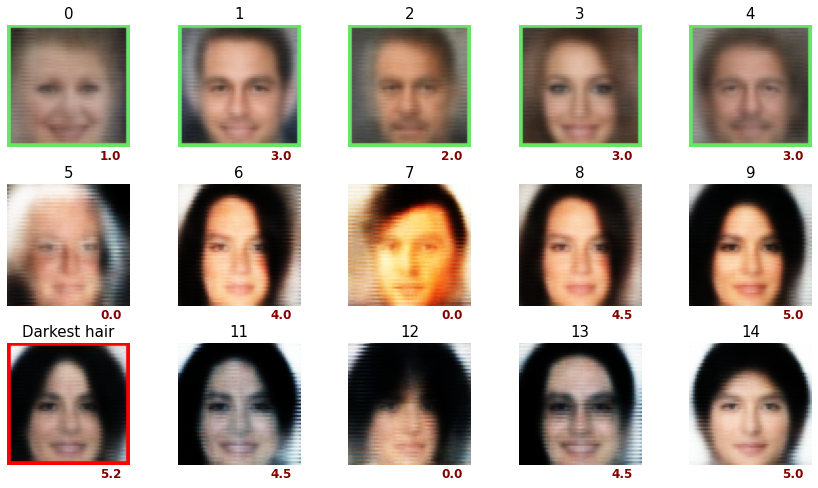

In [15]:
composit = FacialComposit(decoder, bounds)
if do_search:
    composit.query_initial(n_start=5)
    composit.optimize()
else:
    composit.load_state( 'dark_hair.dat' )
composit.draw_all('Darkest hair')

In [ ]:
composit.draw_best('Darkest hair')

#### Task 3.2. Finding person with the widest smile (3 points)

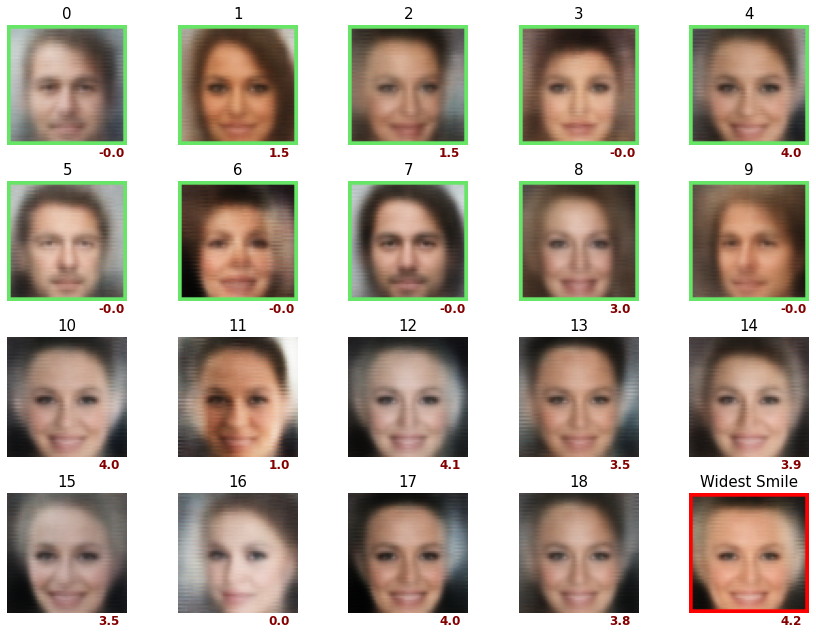

In [17]:
composit = FacialComposit(decoder, bounds)
if do_search:
    composit.query_initial(n_start=10, min_select=3)
    composit.optimize()
else:
    composit.load_state( 'wide_smile.dat' )
composit.draw_all( 'Widest Smile' )

In [ ]:
composit.draw_best('Widest smile')

#### Task 3.3. Finding Daniil Polykovskiy or Alexander Novikov — lecturers of this course (3 points) 

Note: this task highly depends on the quality of a VAE and a search algorithm. You may need to restart your search algorithm a few times and start with larget initial set.

**Note**

Here, it let the decoder generate 25 random images and scored only a few that shared some features with the face of Alexander Novikov. Then I terminated the query and let the application assing a sore of 0 to all remaining candidates.

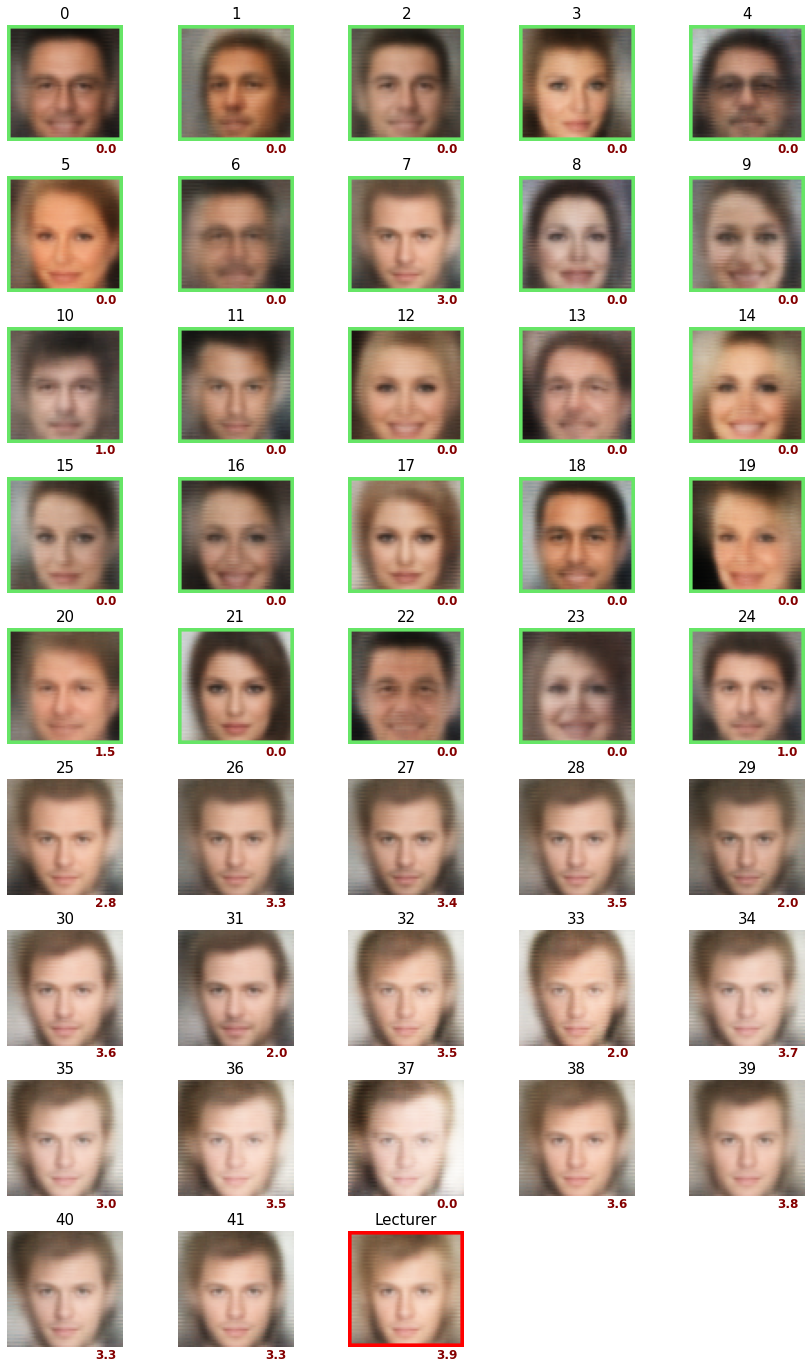

In [19]:
composit = FacialComposit(decoder, bounds)
if do_search:
    composit.query_initial(
        n_start=25,
        min_select=1,
        max_select=10,
    )
    composit.optimize(exploration_weight=2)
else:
    composit.load_state( 'lecturer.dat' )
composit.draw_all('Lecturer')

In [ ]:
composit.draw_best('Lecturer')

#### <small>Don't forget to post resulting image of lecturers on the forum ;)</small>

#### Task 3.4. Finding specific person (optional, but very cool)

Now that you have a good sense of what your algorithm can do, here is an optional assignment for you. Think of a famous person and take look at his/her picture for a minute. Then use your app to create an image of the person you thought of. You can post it in the forum <a href="https://www.coursera.org/learn/bayesian-methods-in-machine-learning/discussions/forums/SE06u3rLEeeh0gq4yYKIVA">Final project: guess who!</a>


In [ ]:
### Your code here